In [1]:
import pandas as pd
%cd /home/ltchen/gnnpp
import sys
import json
import copy
from torch_geometric.loader import DataLoader
from torch.utils.data import TensorDataset
import shap
import matplotlib.pyplot as plt
from exploration.get_graphs_and_data import *
from utils.explainability_utils import *
import seaborn as sns

/home/ltchen/gnnpp


/home/ltchen/.conda/envs/gnn_env4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
DIRECTORY = os.getcwd()
leadtimes = ["24h", "72h", "120h"]
data_type = "rf"
graph_name = "g1"
drn = False

all_feature_names, grouped_list = get_feature_list()
grouped_list = ['id',
 'orography',
 'altitude',
 'latitude',
 'longitude',
 'cape',
 'sd',
 'stl1',
 'swvl1',
 't2m',
 'tcc',
 'tcw',
 'tcwv',
 'u10',
 'u100',
 'v10',
 'v100',
 'vis',
 'cp6',
 'mn2t6',
 'mx2t6',
 'p10fg6',
 'slhf6',
 'sshf6',
 'ssr6',
 'ssrd6',
 'str6',
 'strd6',
 'tp6',
 'z',
 'q',
 'u',
 'v',
 't',
 'doy']

In [46]:
dfs = []

for leadtime in leadtimes:
    JSONPATH, SAVEPATH, RESULTPATH = get_json_save_result_paths(leadtime=leadtime, graph_name=graph_name, drn=drn)
    print(RESULTPATH)
    old_df = pd.read_csv(os.path.join(RESULTPATH, f"permutation_importance_{data_type}.csv"))
    old_df.rename(columns={
        f'CRPS_mean_{leadtime}': 'CRPS_mean',
        f'CRPS_std_{leadtime}': 'CRPS_std',
    }, inplace=True)
    old_df['leadtime'] = leadtime
    crps_value = float([line for line in open(os.path.join(RESULTPATH, f"{data_type}.txt")) if line.startswith('Final crps:')][0].split(':')[1])
    print(crps_value)
    new_df = old_df[['Feature', 'CRPS_mean', 'CRPS_std', 'leadtime']]
    new_df['relCRPS_mean'] = (new_df['CRPS_mean'] - crps_value) / crps_value
    new_df = new_df[['Feature', 'relCRPS_mean', 'CRPS_std', 'leadtime']]
    dfs.append(new_df)
df = pd.concat(dfs, axis=0)
df

/home/ltchen/gnnpp/leas_trained_models/sum_stats_24h/g1_24h/
0.6189686617958247
/home/ltchen/gnnpp/leas_trained_models/sum_stats_72h/g1_72h/
0.8457577004251705
/home/ltchen/gnnpp/leas_trained_models/sum_stats_120h/g1_120h/
1.1843842446947757


/tmp/ipykernel_2830328/2897592377.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['relCRPS_mean'] = (new_df['CRPS_mean'] - crps_value) / crps_value
/tmp/ipykernel_2830328/2897592377.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['relCRPS_mean'] = (new_df['CRPS_mean'] - crps_value) / crps_value
/tmp/ipykernel_2830328/2897592377.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

,Feature,relCRPS_mean,CRPS_std,leadtime
0,id,0.556302,0.000210,24h
1,orography,0.036581,0.000188,24h
2,altitude,0.125632,0.000865,24h
3,latitude,0.114689,0.001720,24h
4,longitude,0.030204,0.000268,24h
...,...,...,...,...
30,q,0.002154,0.001609,120h
31,u,0.004809,0.003454,120h
32,v,0.003968,0.002109,120h
33,t,0.028532,0.000794,120h


In [47]:
times_to_shuff = 3
crps_shuff_cols = ['Feature'] + [f"CRPS_{shuffle_id}" for shuffle_id in range(0, times_to_shuff)]
print(crps_shuff_cols)

dfs = []
for leadtime in leadtimes:
    JSONPATH, SAVEPATH, RESULTPATH = get_json_save_result_paths(leadtime=leadtime, graph_name=graph_name, drn=drn)
    print(RESULTPATH)
    old_df = pd.read_csv(os.path.join(RESULTPATH, f"permutation_importance_{data_type}.csv"))
    df_long = old_df[crps_shuff_cols].melt(id_vars=['Feature'], var_name='Shuffle', value_name='CRPS')
    df_long['Shuffle'] = df_long['Shuffle'].str.split('_').str[1]
    df_long['leadtime'] = leadtime
    crps_value = float([line for line in open(os.path.join(RESULTPATH, f"{data_type}.txt")) if line.startswith('Final crps:')][0].split(':')[1])
    print(crps_value)
    new_df = df_long
    new_df['relCRPS'] = (new_df['CRPS'] - crps_value) / crps_value
    # new_df = new_df[['Feature', 'relCRPS', 'leadtime']]
    print(new_df)
    dfs.append(new_df)
df = pd.concat(dfs, axis=0)
df

['Feature', 'CRPS_0', 'CRPS_1', 'CRPS_2']
/home/ltchen/gnnpp/leas_trained_models/sum_stats_24h/g1_24h/
0.6189686617958247
       Feature Shuffle      CRPS leadtime   relCRPS
0           id       0  0.963329      24h  0.556345
1    orography       0  0.641664      24h  0.036666
2     altitude       0  0.696936      24h  0.125964
3     latitude       0  0.688679      24h  0.112623
4    longitude       0  0.637760      24h  0.030359
..         ...     ...       ...      ...       ...
100          q       2  0.625260      24h  0.010164
101          u       2  0.627825      24h  0.014309
102          v       2  0.625747      24h  0.010951
103          t       2  0.748847      24h  0.209830
104        cos       2  0.653190      24h  0.055287

[105 rows x 5 columns]
/home/ltchen/gnnpp/leas_trained_models/sum_stats_72h/g1_72h/
0.8457577004251705
       Feature Shuffle      CRPS leadtime   relCRPS
0           id       0  1.158363      72h  0.369615
1    orography       0  0.862577      72h  0.0

,Feature,Shuffle,CRPS,leadtime,relCRPS
0,id,0,0.963329,24h,0.556345
1,orography,0,0.641664,24h,0.036666
2,altitude,0,0.696936,24h,0.125964
3,latitude,0,0.688679,24h,0.112623
4,longitude,0,0.637760,24h,0.030359
...,...,...,...,...,...
100,q,2,1.188579,120h,0.003542
101,u,2,1.190170,120h,0.004885
102,v,2,1.186878,120h,0.002105
103,t,2,1.217894,120h,0.028293


In [21]:
f_list = ['stl1_mean', 'stl1_std']
if isinstance(f_list, list):
    f = f_list[0].split("_")[0]
else:
    f = f_list
print(f)


stl1


In [30]:
def normalize_category(group):
    group = group / group.mean().sum()
    return group

df = df.groupby(["leadtime", 'Feature']).apply(normalize_category).reset_index().drop(columns=["level_1"])
df

TypeError: unsupported operand type(s) for /: 'str' and 'float'

In [49]:
# was berechne ich hier überhaupt?
df['normalized_importance'] = df.groupby(['leadtime'])['relCRPS'].transform(
    lambda x: (x / x.sum())
)
df.sort_values(by=['normalized_importance'], ascending=False, inplace=True)
df

,Feature,Shuffle,CRPS,leadtime,relCRPS,normalized_importance
9,t2m,0,2.188706,24h,2.536053,0.121087
79,t2m,2,2.161870,24h,2.492696,0.119017
44,t2m,1,2.130368,24h,2.441802,0.116587
9,t2m,0,1.520111,72h,0.797337,0.074439
44,t2m,1,1.519058,72h,0.796091,0.074323
...,...,...,...,...,...,...
48,u10,1,1.184442,120h,0.000049,0.000009
5,cape,0,0.845628,72h,-0.000154,-0.000014
11,tcw,0,1.183891,120h,-0.000417,-0.000077
52,vis,1,1.183859,120h,-0.000444,-0.000082


In [43]:
pi_df = df.groupby(['leadtime', 'Feature']).sum(numeric_only=True).sort_values(by='normalized_importance', ascending=False)

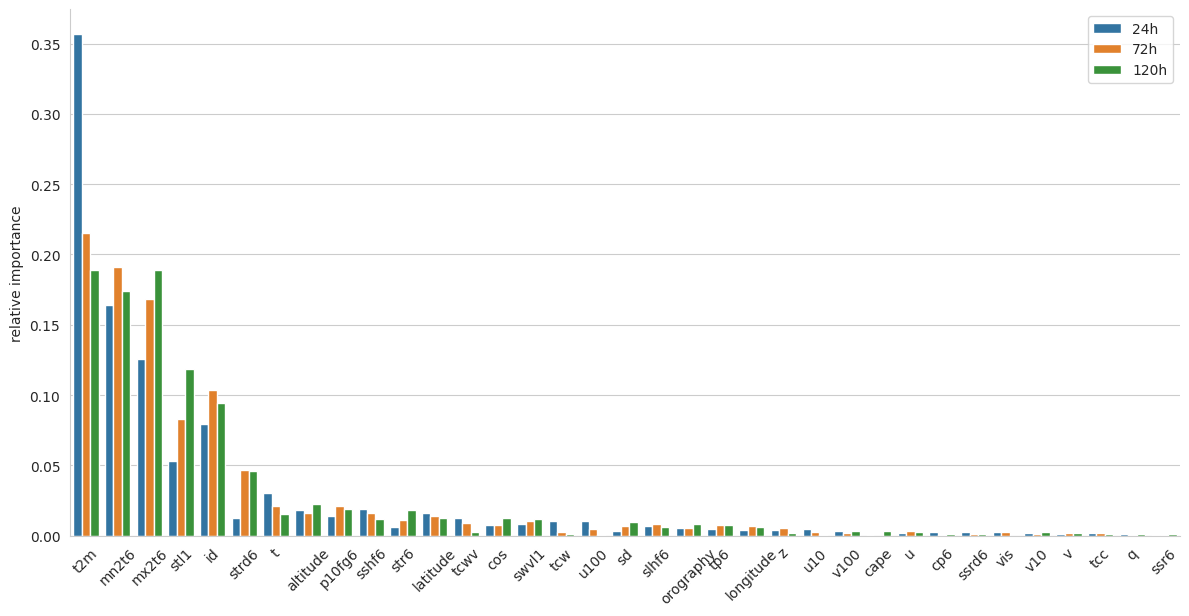

In [44]:
sns.set_style("whitegrid")
# c = [get_color(lead_time)(0.6) for lead_time in ["24h", "72h", "120h"]]
pi_df.sort_values(by=['normalized_importance'], ascending=False, inplace=True)
g = sns.catplot(data=pi_df, kind="bar",
                x="Feature", y="normalized_importance", hue="leadtime", hue_order=["24h", "72h", "120h"],
                errorbar="sd", height=6, aspect=2,
                legend_out=None)
g.set_axis_labels("", "relative importance")
g.legend.set_title("")

g.set(ylim=(0, None))

# Rotate x-axis labels by 45 degrees
g.set_xticklabels(rotation=45)

# Save
#tikzplotlib_fix_ncols(g.ax)
#tikzplotlib.save(f"figures/PI_{DATASET}.tex")